# Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Preparing the Data 

In [2]:
# Load the CSV files
df_augmented= pd.read_csv('dataset/csvs/augmented.csv')
test_df = pd.read_csv('dataset/csvs/test_df.csv')
val_df = pd.read_csv('dataset/csvs/val_df.csv')

In [4]:
def file_exists(file_paths):
    # Filter out non-existing files
    return [file_path for file_path in file_paths if os.path.exists(file_path)]

def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Filter out filenames that do not exist
    valid_filenames = file_exists(filenames)
    valid_labels = labels[np.isin(filenames, valid_filenames)]  # Keep labels corresponding to the valid filenames

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((valid_filenames, valid_labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(valid_filenames))
    dataset = dataset.batch(batch_size)
    return dataset

def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label



In [5]:
def load_and_prepare_aug_dataset(df, images_dir, shuffle=True, batch_size=32):
    # Concatenate the directory with filenames to get the full image paths
    images = images_dir + df['filename'].astype(str)
    
    # Convert labels to the correct format if they are not already (e.g., one-hot encoding)
    # This step depends on how your labels are formatted and what your model expects
    labels = df['target'].values
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(parse_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch data for performance
    
    return dataset
df_augmented['target'] = df_augmented['target'].apply(lambda x: str(x))



In [6]:
train_ds = load_and_prepare_aug_dataset(df_augmented, 'dataset/augmented_images/', shuffle=True, batch_size=16)
val_ds = load_and_prepare_dataset(val_df, 'dataset/preprocessed_images/', shuffle=False, batch_size=16)
test_ds = load_and_prepare_dataset(test_df, 'dataset/preprocessed_images/', shuffle=False, batch_size=16)

In [7]:
print("size of training dataset: ", train_ds.cardinality().numpy())
print("size of validation dataset: ", val_ds.cardinality().numpy())
print("size of test dataset: ", test_ds.cardinality().numpy())

size of training dataset:  544
size of validation dataset:  125
size of test dataset:  156


# Loading and Visualising the Training Data 

Training dataset
(16, 299, 299, 3)
(16, 8)


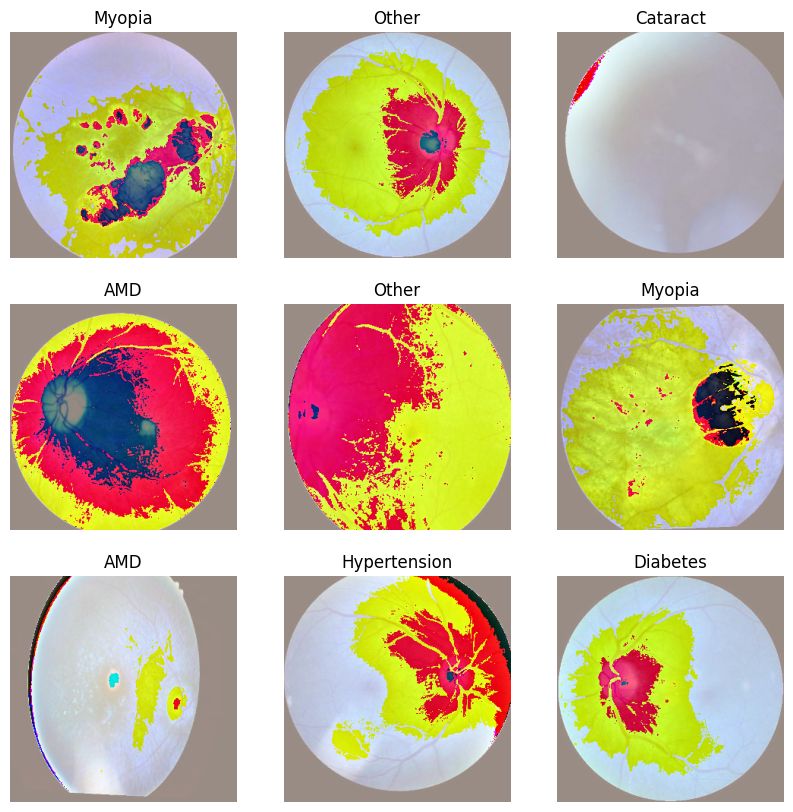

In [8]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(16, 224, 224, 3)
(16, 8)


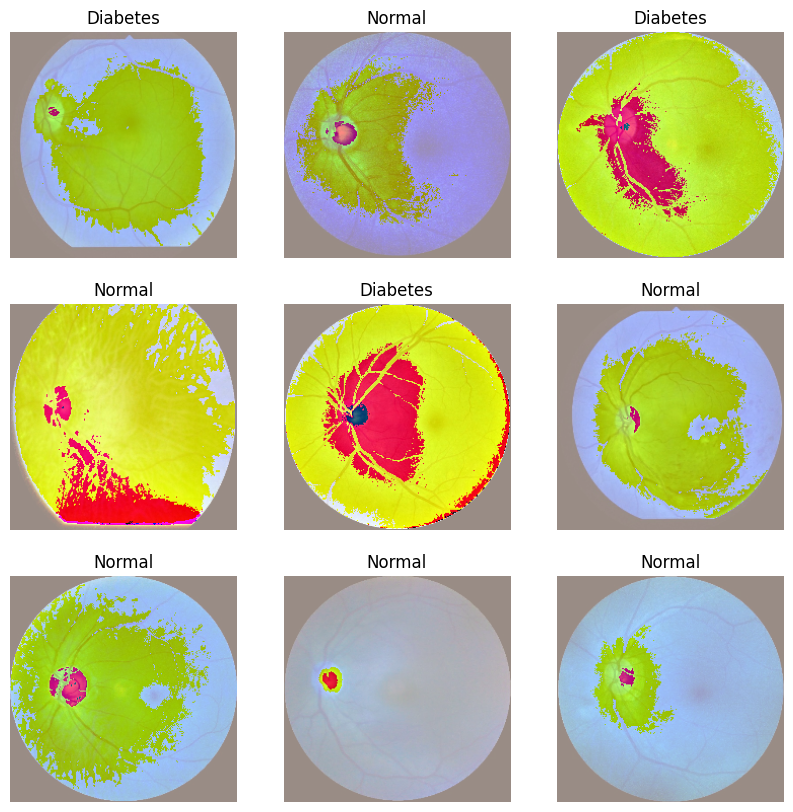

In [10]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

In [30]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model_VGG16.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1) # increased patience from 3 to 5 and factor from 0.2 to 0.5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # increased from 5 to 10


callbacks = [early_stopping, checkpoint, reduce_lr]

In [31]:
from keras.layers import Dropout, BatchNormalization, Activation


In [32]:
vgg_16_model = Sequential()

pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

vgg_16_model.add(pretrained_model)
vgg_16_model.add(Flatten())
vgg_16_model.add(Dense(64, activation='relu'))
vgg_16_model.add(Dropout(0.3))

vgg_16_model.add(Dense(8, activation='softmax'))

In [33]:
vgg_16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 14,748,040
Trainable params: 33,352
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
vgg_16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
epochs =  50
history = vgg_16_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/50


544/544 [==============================] - ETA: 0s - loss: 2.6146 - accuracy: 0.2809
Epoch 1: val_loss improved from inf to 1.90335, saving model to best_model_VGG16.h5
544/544 [==============================] - 69s 106ms/step - loss: 2.6146 - accuracy: 0.2809 - val_loss: 1.9034 - val_accuracy: 0.2504 - lr: 1.0000e-04
Epoch 2/50
544/544 [==============================] - ETA: 0s - loss: 1.6263 - accuracy: 0.3786
Epoch 2: val_loss improved from 1.90335 to 1.77374, saving model to best_model_VGG16.h5
544/544 [==============================] - 69s 107ms/step - loss: 1.6263 - accuracy: 0.3786 - val_loss: 1.7737 - val_accuracy: 0.2891 - lr: 1.0000e-04
Epoch 3/50
544/544 [==============================] - ETA: 0s - loss: 1.4743 - accuracy: 0.4382
Epoch 3: val_loss improved from 1.77374 to 1.73054, saving model to best_model_VGG16.h5
544/544 [==============================] - 73s 111ms/step - loss: 1.4743 - accuracy: 0.4382 - val_loss: 1.7305 - val_accuracy: 0.3228 - lr: 1.0000e-04
Epoch 4/50

# Evaluating Model 

Model Accuracy Graph Analysis

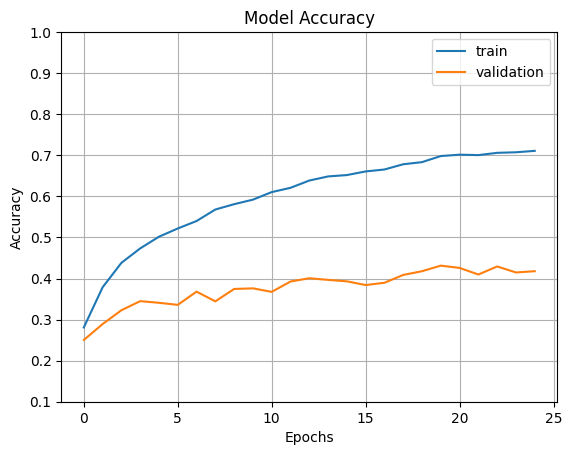

In [36]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

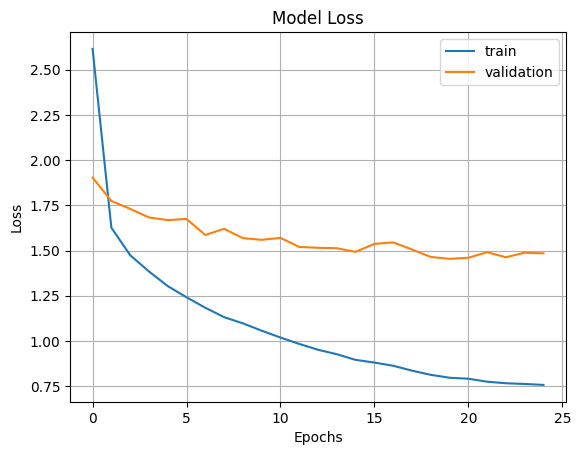

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Fine tuning 

In [ ]:
#fine tune
#unfreeze 10 layers
for layer in vgg_16_model.layers[-5:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

    
vgg_16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 50
history = vgg_16_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)


# Making Predictions

156/156 [==============================] - 14s 84ms/step - loss: 1.4403 - accuracy: 0.4443
Evaluation results: [1.4402992725372314, 0.44431090354919434]
156/156 [==============================] - 13s 82ms/step


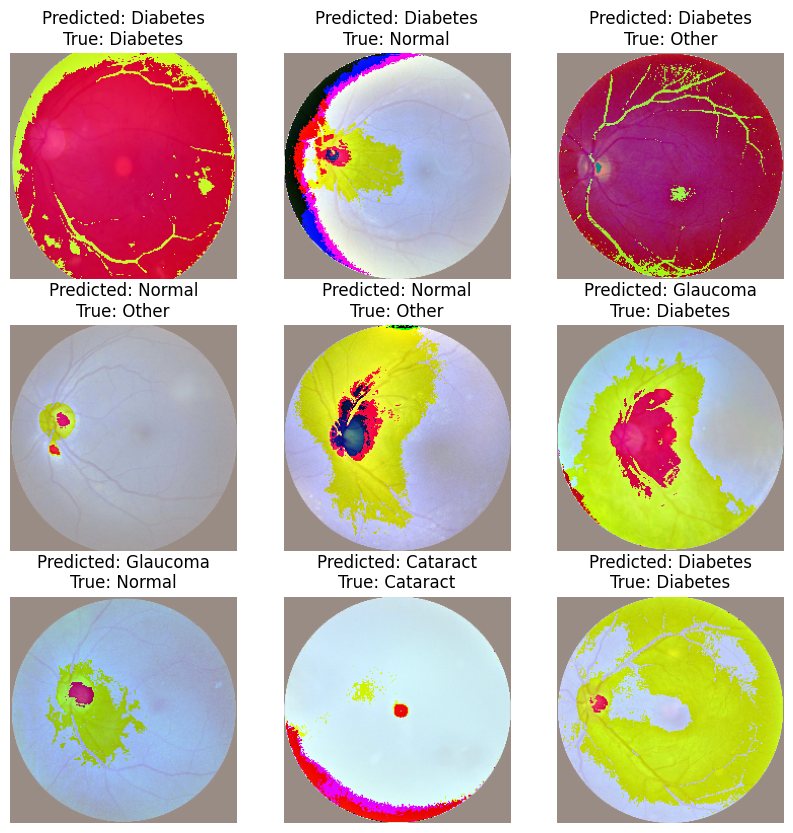

In [39]:
from tensorflow.keras.models import load_model

# Load the saved model
vgg_16_model = load_model('best_model_VGG16.h5')

# Evaluate the model on the test dataset
evaluation_results = vgg_16_model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = vgg_16_model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Predictions Result Evaluation

In [40]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [41]:
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Shape of true_labels after vstack: (2496, 8)


In [42]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.57      0.44      0.50      1122
      Diabetes       0.40      0.47      0.43       632
      Glaucoma       0.26      0.44      0.33       112
      Cataract       0.54      0.82      0.65       114
           AMD       0.41      0.37      0.39       104
  Hypertension       0.18      0.24      0.21        49
        Myopia       0.68      0.80      0.74        85
Other diseases       0.20      0.19      0.20       278

      accuracy                           0.44      2496
     macro avg       0.41      0.47      0.43      2496
  weighted avg       0.46      0.44      0.45      2496



Balanced Accuracy Score 

In [47]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4716


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [48]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.7863


Confusion Matrix 

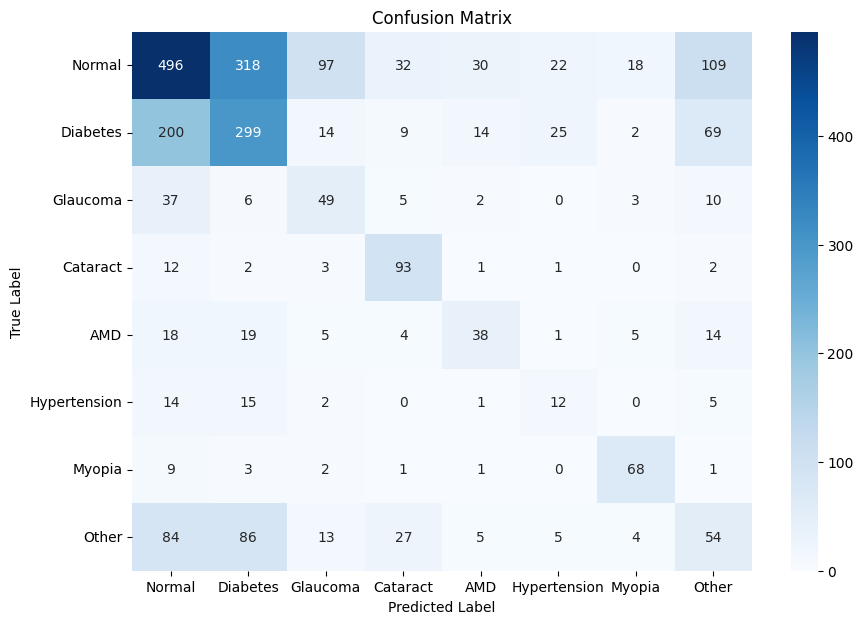

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

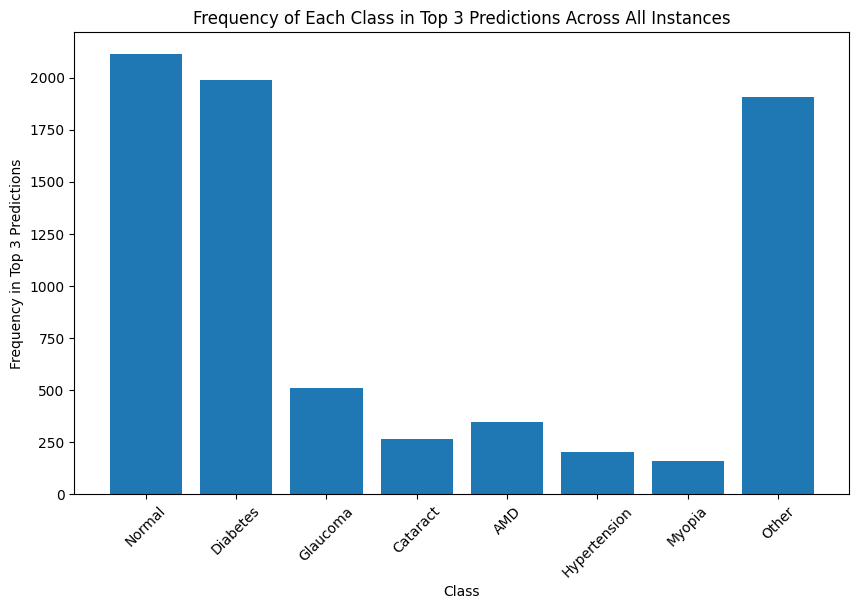

In [51]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()